In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from sklearn.metrics import accuracy_score
from warnings import filterwarnings
filterwarnings('ignore')
import matplotlib.pyplot as plt

In [2]:
# Define data directories
train_dir = r'D:\Git Projects\Peppermint-Identification-and-Classification-Model\Identification\Data\train'
test_dir = r"D:\Git Projects\Peppermint-Identification-and-Classification-Model\Identification\Data\test"
validation_dir = r'D:\Git Projects\Peppermint-Identification-and-Classification-Model\Identification\Data\validation'

In [3]:
datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input
)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

validation_generator = datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)
test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Do not shuffle the data for evaluation
)


Found 17469 images belonging to 7 classes.
Found 3740 images belonging to 7 classes.
Found 3737 images belonging to 7 classes.


In [4]:
# Load pre-trained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze convolutional layers
for layer in base_model.layers:
    layer.trainable = False

# Create a custom classification head
x = Flatten()(base_model.output)
x = Dense(128, activation='relu')(x)
x = Dense(7, activation='softmax')(x)  # 2 classes

model = Model(base_model.input, x)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=10,
    validation_data=validation_generator,
    validation_steps=len(validation_generator)
)






546/546 [==============================] - 2602s 5s/step - loss: 0.2747 - accuracy: 0.9871 - val_loss: 0.0545 - val_accuracy: 0.9944


In [5]:
# Generate predictions on the test data
predictions = model.predict(test_generator, steps=len(test_generator))
y_pred = predictions.argmax(axis=1)
y_true = test_generator.classes

# Get the class labels
class_labels = list(test_generator.class_indices.keys())

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)

# Create a classification report
report = classification_report(y_true, y_pred, target_names=class_labels)

# Print accuracy
print("Accuracy:", accuracy)

# Print classification report
print(report)

117/117 [==============================] - 252s 2s/step
Accuracy: 0.9965212737489966
                                                 precision    recall  f1-score   support

                             Apple Leaf Dataset       1.00      1.00      1.00       102
                   Coconut Tree Disease Dataset       1.00      1.00      1.00       869
Plumbago Zeylanica (Chitrak) Leaf Image Dataset       1.00      1.00      1.00      1599
                                         Pudina       0.99      1.00      0.99       861
                                 Random Objects       0.97      1.00      0.99       152
                                         Tomato       1.00      0.82      0.90        45
                                          Tulsi       1.00      0.95      0.98       109

                                       accuracy                           1.00      3737
                                      macro avg       0.99      0.97      0.98      3737
                       

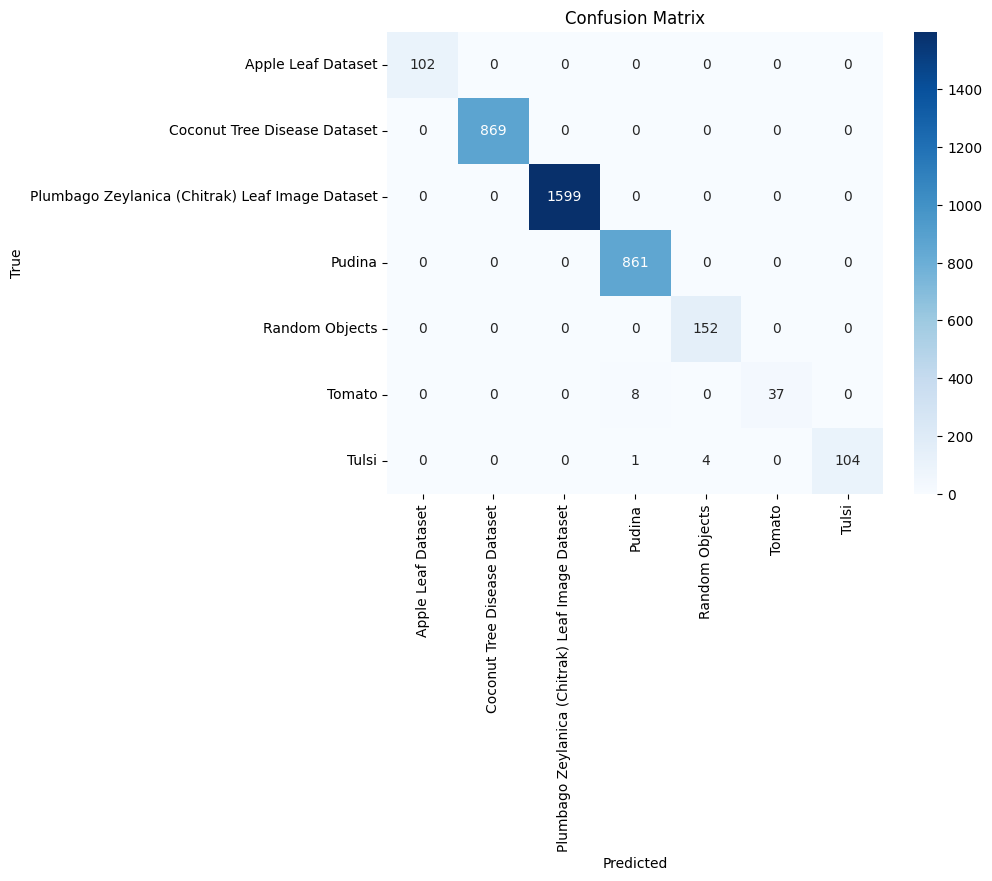

In [6]:
# Create a confusion matrix heatmap
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [7]:
model.save('peppermint.h5')